shape is (482, 9)
shape is (482, 1)
loss 0.1425693165510893
Val_loss 0.5257143415510654
relative_error 1.2257495517572405


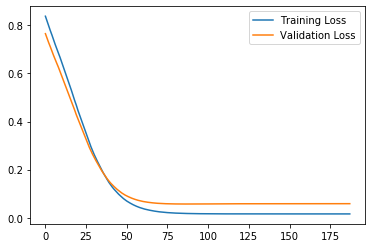

In [14]:
from tensorflow.keras import Input, layers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import numpy.linalg as la 
import scipy.io
import matplotlib.pyplot as plt

# load training and test sets
mat = scipy.io.loadmat('X')
x_train = np.transpose(mat['X'])
mat = scipy.io.loadmat('Y')
x_test = np.transpose(mat['Y'])

# give weights
mat = scipy.io.loadmat('W')
weights = np.transpose(mat['W'])

print('shape is',x_train.shape)
print('shape is',weights.shape)

# degree of freedoms for CVs
encoding_dim = 2  


# set Input
input_img = Input(shape=(x_train.shape[1],))

# layers between input and bottleneck
encoded = layers.Dense(1000, activation='tanh')(input_img)
encoded_2 = layers.Dense(2, activation='tanh')(encoded)

# set encoder
encoder = Model(input_img, encoded_2)

# set input for decoder
decoder_input = Input(shape=(encoding_dim,))

# Layers between bottleneck and output
decoded = layers.Dense(1000, activation='tanh')(decoder_input)
decoded_2 = layers.Dense(x_train.shape[1])(decoded)

# set decoder
decoder = Model(decoder_input,decoded_2)

# 
auto_encoder_input =  Input(shape=(x_train.shape[1],))
auto_encoder_encoder_out = encoder(auto_encoder_input)
auto_encoder_decoder_out = decoder(auto_encoder_encoder_out)
autoencoder = Model(auto_encoder_input, auto_encoder_decoder_out)

callback = EarlyStopping(monitor='val_loss', patience=100)


opt = optimizers.SGD(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='mse')


history = autoencoder.fit(x_train, x_train,
                epochs=2000,
                batch_size=30,
                sample_weight=weights,
                shuffle=True,
                callbacks=[callback],
                verbose=0,
                validation_data=(x_test, x_test))
# loss = 1/(M*d)* sum of squares of errors, where M is the size of training set and d is the dimension of input vector
# validation loss is defined similarly over the test set, instead of M, m as the size of test set

# Encoder and decoder
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

CV = encoder.predict(x_train)

file_name = 'CV.mat'
scipy.io.savemat(file_name, {'CV': CV})

n = x_train.shape[0]*x_train.shape[1]
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
print('loss',x_train.shape[1]*history.history["loss"][-1])
print('Val_loss',x_train.shape[1]*history.history["val_loss"][-1])
print('relative_error',x_train.shape[0]*x_train.shape[1]*history.history["loss"][-1]/la.norm(x_train,'fro'))

In [15]:
x = np.array([x_train[0,:]])
y = encoder.predict(x)
print(la.norm(x-decoder.predict(y)))
print(y)
x = np.array([x_train[1,:]])
y = encoder.predict(x)
print(la.norm(x-decoder.predict(y)))
print(y)

0.9739932968993598
[[0.89576346 0.7253718 ]]
0.24796515020697232
[[0.9476754  0.85649025]]


In [58]:

# call two local minima
x_loc_1 = encoder.predict(np.array([x_train[0,:]]))

x_loc_2 = encoder.predict(np.array([x_train[57,:]]))

# Generate uniform grid between two local minima

if x_loc_1[0][0] < x_loc_2[0][0]:
    x = np.linspace(x_loc_1[0][0], x_loc_2[0][0], num=10)
    print('loc_1(x)<loc_2(x)')
else:
    x = np.linspace(x_loc_2[0][0], x_loc_1[0][0], num=10)
    print('loc_2(x)<loc_1(x)')
    
if x_loc_1[0][1] < x_loc_2[0][1]:
    y = np.linspace(x_loc_1[0][1], x_loc_2[0][1], num=10)
    print('loc_1(y)<loc_2(y)')
else:
    y = np.linspace(x_loc_2[0][1], x_loc_1[0][1], num=10)
    print('loc_2(y)<loc_1(y)')

cv = np.concatenate((np.array([x]),np.array([y])), axis=0)    

A = np.array([np.zeros(x_train.shape[1])])
for i in range(0,10):
    for j in range(0,10):
        pt = np.array([[x[i],y[j]]])
        A = np.concatenate((A,decoder.predict(pt)), axis=0)

A = np.transpose(A[1:,:])

scipy.io.savemat('cv.mat', {'cv': cv})
scipy.io.savemat('A.mat', {'A': A})  

1/1 [==============================] - 0s 28ms/step
loc_1(x)<loc_2(x)
loc_2(y)<loc_1(y)
1/1 [==============================] - 0s 29ms/step


In [17]:
import tensorflow as tf
y_true = [[0],[0]]
y_pred = [[2],[4]]
 # Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
mse(y_true, y_pred, sample_weight=[0.5,2]).numpy()

17

In [46]:
x_test.shape

(2002, 9)